Copyright (c) 2019 Primoz Ravbar UCSB Licensed under BSD 2-Clause [see LICENSE for details] Written by Primoz Ravbar

This batch processes ST-images (3C) into ethograms. 

In [25]:
# get the prob matrix and movement matrix (signal level) from 3C ST images

import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.colors as mcolors
import natsort
from PIL import Image

from sklearn.utils import shuffle

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

from ABRS_modules import discrete_radon_transform
from ABRS_modules import etho2ethoAP
from ABRS_modules import smooth_1d

#The path for the ABRS folder
pathToABRS_GH_folder = 'D:\\ABRS'

#The path for the 3C images
topInputFolder = 'D:\\ABRS\\Data\\3C'

modelName = 'modelConv2ABRS_3C_train_with_descendingcombinedwithothers_avi_10' 
model = keras.models.load_model(modelName)
model.summary()

#Output folder
outputFolderEtho = pathToABRS_GH_folder + '\\Output';

storeFrameRec = 0

normalizeByMax = 1;
thresholdMovement = 10;

subfolderList = sorted(os.listdir(topInputFolder))

startNewEtho = 1
firstFolder = 0

#The number of subfolders (flies)
numbSubfolders = 4

#The total length (frames) of the movie
lengthEtho = 5*50

if startNewEtho == 1:

    ethoMat = np.zeros((1, lengthEtho))
    probMat = np.zeros((10, lengthEtho))
    ethoMovementMat = np.zeros((1, lengthEtho))

for fld in range(firstFolder, numbSubfolders, 1):

    inputSubfolderName = subfolderList[fld]
    print(inputSubfolderName)

    inputSubfolderPathName = topInputFolder + '\\' + inputSubfolderName

    print(inputSubfolderPathName)


    fileList = sorted(os.listdir(inputSubfolderPathName))

    numbFiles = np.shape(fileList)[0]; 
    skipFilesNumb = 1;
    skipFrameNumb = 1;

    yi = np.zeros((1, 10))
    yiVect = np.zeros((1, 1))

    if storeFrameRec == 1:
        rtImRec = np.zeros((np.shape(fileList)[0] * 50, 80, 80, 3))

    predictionsProbDataRec = np.zeros((10, lengthEtho))

    etho = np.zeros((1, lengthEtho))
    ethoMovement = np.zeros((1, lengthEtho))

    indIm = 0

    for fl in range(0, numbFiles - 0, skipFilesNumb):  #

        inputFileName = fileList[fl];
        print(inputFileName);

        fileDirPathInputName = inputSubfolderPathName + '\\' + inputFileName;

        with open(fileDirPathInputName, "rb") as f:
            dict3C = pickle.load(f)

        recIm3C = dict3C["recIm3C"]

        maxMovRec = dict3C['maxMovementRec'];

        for i in range(0, recIm3C.shape[0] - 0, skipFrameNumb):

            im3CRaw = recIm3C[i, :, :, :] / 1

            if np.count_nonzero(im3CRaw[:, :, 0]) > 5500:
                im3CRaw[:, :, 0] = np.zeros((80, 80))

            if np.count_nonzero(im3CRaw[:, :, 1]) > 800:
                im3CRaw[:, :, 1] = np.zeros((80, 80))

            rgbArray = np.zeros((80, 80, 3), 'uint8')
            rgbArray[..., 0] = im3CRaw[:, :, 0]
            rgbArray[..., 1] = im3CRaw[:, :, 1]
            rgbArray[..., 2] = im3CRaw[:, :, 2]
            im3C = Image.fromarray(rgbArray)

            if storeFrameRec == 1:
                rtImRec[indIm, :, :, :] = im3C

            X_rs = np.zeros((1, 80, 80, 3))

            X_rs[0, :, :, :] = im3C

            X = X_rs / 256

            predictionsProbData = model.predict(X)

            predictionsProbData[0, 2] = predictionsProbData[0, 2] + 0.0
            predictionsProbData[0, 5] = predictionsProbData[0, 5] + 0.0

            predictionsProbDataRec[:, indIm] = predictionsProbData

            predictionLabelData = np.zeros((1, np.shape(predictionsProbData)[0]))

            etho[0, indIm] = np.argmax(predictionsProbData, axis=1)

            ethoMovement[0, indIm] = maxMovRec[i]

            if maxMovRec[i] < thresholdMovement:
                # behSignal[0,indIm]=1
                # print(maxMovRec[i]);print('No movement detected')
                etho[0, indIm] = 7

            indIm = indIm + 1

    probMat = np.vstack((probMat, predictionsProbDataRec))
    ethoMat = np.vstack((ethoMat, etho))
    ethoMovementMat = np.vstack((ethoMovementMat, ethoMovement))

with open(outputFolderEtho + '\\ethoMatRawJaneliaWin16_MOD12.pickle', "wb") as f:
    pickle.dump(ethoMat, f)
with open(outputFolderEtho +'\\ethoMovementMatJaneliaWin16.pickle', "wb") as f:
    pickle.dump(ethoMovementMat, f)
with open(outputFolderEtho +'\\probMatJaneliaWin16.pickle', "wb") as f:
    pickle.dump(probMat, f)
#The file list
with open(outputFolderEtho +'\\subfolderList.pickle', "wb") as f:
    pickle.dump(subfolderList, f)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 76, 76, 16)        1216      
_________________________________________________________________
activation_4 (Activation)    (None, 76, 76, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 16)        6416      
_________________________________________________________________
activation_5 (Activation)    (None, 34, 34, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 16)       

0
1
2
3
4


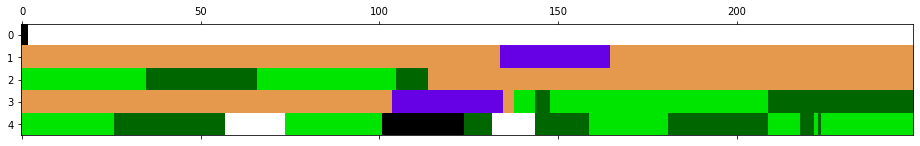

In [17]:
#Generate the final ethograms

ethoPath = 'D:\\ABRS\\Output'

with open(ethoPath + '\\' + 'ethoMatRawJaneliaWin16_MOD12.pickle', "rb") as f:
    ethoMatLoaded = pickle.load(f)
with open(ethoPath + '\\' + 'ethoMovementMatJaneliaWin16.pickle', "rb") as f:
    ethoMovementMatLoaded = pickle.load(f)
with open(ethoPath + '\\' + 'probMatJaneliaWin16.pickle', "rb") as f:
    probMatLoaded = pickle.load(f)

ethoMatLoaded[0, 2] = 0;
ethoMatLoaded[0, 3] = 7

probMat = probMatLoaded
ethoMat = ethoMatLoaded
ethoMovementMat = ethoMovementMatLoaded

# smooth the prob matrix and movement matrix
probMatSmWhole = smooth_1d (probMat, 29) #29 for 30Hz; 59 for 60Hz
ethoMovementMatSm = smooth_1d (ethoMovementMat, 89)

# construct ethogram matrix ethoMatNew from prob matrix
thWk = 0.5  # prob of walking
thSignal = 110  # Threshold for standing
#thSignal = 170  # variation1


#The threshold between front leg grooming and head grooming
thresholdFHbaseline = 0 #default should be 0; this moves the thresholds up or down
#The threshold between back leg grooming and abdominal grooming
thresholdABbaseline = -0.0

ethoMatNew = np.zeros((np.shape(ethoMat)[0], np.shape(ethoMat)[1]))
probBehDiffMatFH = np.zeros((np.shape(ethoMat)[0], np.shape(ethoMat)[1]))

indEtho = 0

for p in range(0, np.shape(probMat)[0], 10):

    probMatSm = probMatSmWhole[p:p + 9, :]

    ethoMovementMatCurrent = np.zeros((1, np.shape(probMat)[1]))
    ethoMovementMatCurrent[0, :] = ethoMovementMatSm[indEtho, :]

    newEthoFH = np.zeros((1, np.shape(probMat)[1]))
    newEthoAB = np.zeros((1, np.shape(probMat)[1]))
    newEthoW = np.zeros((1, np.shape(probMat)[1]))
    newEthoWk = np.zeros((1, np.shape(probMat)[1]))

    newEthoFull = np.zeros((1, np.shape(probMat)[1]))

    maxEtho = np.zeros((1, np.shape(probMat)[1]))
    maxEtho[0, :] = np.argmax(probMatSm[0:8, :], axis=0)

    probA = np.zeros((1, np.shape(probMat)[1]))
    probA[0, :] = probMatSm[1, :] + probMatSm[2, :]

    probASm = smooth_1d(probA, 175)

    probP = np.zeros((1, np.shape(probMat)[1]))
    probP[0, :] = probMatSm[3, :] + probMatSm[4, :] + probMatSm[5, :]

    probPSm = smooth_1d(probP, 175)

    probWk = np.zeros((1, np.shape(probMat)[1]))
    probWk[0, :] = probMatSm[6, :]

    diffFH = np.zeros((1, np.shape(probMat)[1]))
    diffFH[0, :] = probMatSm[1, :] - probMatSm[2, :]
    thFH = smooth_1d(diffFH, 239) / 2 - thresholdFHbaseline

    diffAB = np.zeros((1, np.shape(probMat)[1]))
    diffAB[0, :] = probMatSm[3, :] - probMatSm[4, :]
    thAB = smooth_1d(diffAB, 239) / 2 - thresholdABbaseline

    newEthoFH[0, diffFH[0, :] > thFH[0, :]] = 1
    newEthoFH[0, diffFH[0, :] <= thFH[0, :]] = 2
    newEthoFH[0, probASm[0, :] <= probPSm[0, :]] = 0
    newEthoFH[0, probWk[0, :] > thWk] = 0

    newEthoAB[0, diffAB[0, :] > thAB[0, :]] = 3
    newEthoAB[0, diffAB[0, :] <= thAB[0, :]] = 4
    newEthoAB[0, maxEtho[0, :] == 5] = 5
    newEthoAB[0, probPSm[0, :] <= probASm[0, :]] = 0
    newEthoAB[0, probWk[0, :] > thWk] = 0

    newEthoWk[0, probWk[0, :] > thWk] = 6

    newEthoFull = newEthoFH + newEthoAB + newEthoWk

    newEthoFull[0, ethoMovementMatCurrent[0, :] < thSignal] = 7

    probBehDiffMatFH[indEtho, :] = diffFH

    ethoMatNew[indEtho, :] = newEthoFull

    indEtho = indEtho + 1

from ABRS_data_vis import cmapG
from ABRS_data_vis import cmapAP

ethoMatPlot = ethoMatNew
ethoMatPlot[0,0] = 0;ethoMatPlot[0,1] = 7

##### post process ethograms ######

import ABRS_behavior_analysis

rawEthoMat = ethoMatNew

ethoMat = rawEthoMat[0:np.shape(rawEthoMat)[0], :]

shEthoMat = np.shape(ethoMat)

ethoMatPP = np.zeros((shEthoMat[0], shEthoMat[1]))

minDurWalk = 10;
minDurSilence = 5;
minDurAPW = 5;
minDurAPA = 30;


for e in range(0, shEthoMat[0]):
    idx = ethoMat[[e]]
    idxPP = ABRS_behavior_analysis.post_process_etho3(idx, minDurWalk, minDurSilence, minDurAPW, minDurAPA)

    ethoMatPP[e, :] = idxPP

    print(e)

ethoMatPPZ = ethoMatPP;
ethoMatPPZ[0, 1] = 0;


with open(outputFolderEtho +'\\etho.pickle', "wb") as f:
    pickle.dump(ethoMatPPZ, f)

plt.matshow(ethoMatPPZ, interpolation=None, aspect='auto', cmap=cmapG);
plt.show()